In [0]:
import os
import gc
gc.collect()
os.environ['KAGGLE_USERNAME'] = "aaryapatel98"
os.environ['KAGGLE_KEY'] = "a06dc7465c25da061f7b4babffcee5e5"

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [3]:
!pip install pydicom

     |████████████████████████████████| 7.1MB 2.7MB/s 


In [4]:
!kaggle datasets download -d iafoss/siimacr-pneumothorax-segmentation-data-1024 

100% 7.26G/7.26G [01:13<00:00, 89.4MB/s]
100% 7.26G/7.26G [01:13<00:00, 106MB/s] 


In [5]:
!7z x siimacr-pneumothorax-segmentation-data-1024.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 7799998534 bytes (7439 MiB)

Extracting archive: siimacr-pneumothorax-segmentation-data-1024.zip
 15% 4096 Open              --
Path = siimacr-pneumothorax-segmentation-data-1024.zip
Type = zip
Physical Size = 7799998534
64-bit = +

  0%      0% 642 - masks/1.2.276.0.7230010.3.1.4.8323329.10590.1517875224.446778.png                                                                              0% 988 - masks/1.2.276.0.7230010.3.1.4.8323329.10907.1517875227.850816.png

In [6]:
!pip install albumentations > /dev/null
!pip install -U segmentation-models
#!pip install -U efficientnet
import numpy as np
import pandas as pd
import gc

%tensorflow_version 2.x 

import keras
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split,StratifiedKFold

from skimage.transform import resize
import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import  ModelCheckpoint
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras.engine import InputSpec
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.losses import binary_crossentropy
import keras.callbacks as callbacks
from keras.callbacks import Callback
from keras.applications.xception import Xception
from keras.layers import multiply


from keras import optimizers
from keras.legacy import interfaces
from keras.utils.generic_utils import get_custom_objects

from keras.engine.topology import Input
from keras.engine.training import Model
from keras.layers.convolutional import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers.core import Activation, SpatialDropout2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.regularizers import l2
from keras.layers.core import Dense, Lambda
from keras.layers.merge import concatenate, add
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, Permute
from keras.optimizers import SGD,Adam
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

import glob
import shutil
import os
import random
from PIL import Image
import cv2

seed = 10
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
%matplotlib inline

TensorFlow 2.x selected.


Using TensorFlow backend.


In [7]:
print(tf.__version__)

2.0.0


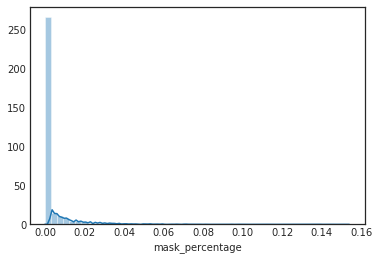

In [8]:
all_mask_fn = glob.glob('/content/masks/*')
mask_df = pd.DataFrame()
mask_df['file_names'] = all_mask_fn
mask_df['mask_percentage'] = 0
mask_df.set_index('file_names',inplace=True)
for fn in all_mask_fn:
    mask_df.loc[fn,'mask_percentage'] = np.array(Image.open(fn)).sum()/(1024*1024*255) #255 is bcz img range is 255
    
mask_df.reset_index(inplace=True)
sns.distplot(mask_df.mask_percentage)
mask_df['labels'] = 0
mask_df.loc[mask_df.mask_percentage>0,'labels'] = 1

In [0]:
train_df,val_df = train_test_split(mask_df,test_size = 0.15,stratify = mask_df.labels,random_state = 100)

In [10]:
print('No. of train files:', len(train_df))
print('No. of val files:', len(val_df))

No. of train files: 10239
No. of val files: 1808


In [0]:
train_filepath = train_df['file_names'].tolist()
val_filepath = val_df['file_names'].tolist()
train_im_path = 'train/train'
train_mask_path = 'masks'
img_size = 512

In [0]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,OpticalDistortion,RandomSizedCrop
)
train_augment = Compose([
    HorizontalFlip(p = 0.5),
    ShiftScaleRotate(p = 0.5),
    ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03,p = 0.5),
    RandomGamma(p = 0.5),
   # ToFloat(max_value = 1)
])

In [0]:
class DataGenerator(keras.utils.Sequence):
    
    def __init__(self,filepath = train_filepath,train_im_path = train_im_path,train_mask_path = train_mask_path,
                 augmentations = None,img_size = img_size,batch_size = 64,nchannels = 3,shuffle = True):
        
        self.train_im_paths = list(filepath)
        self.train_im_path = train_im_path
        self.train_mask_path = train_mask_path
        self.img_size = img_size
        self.batch_size = batch_size
        self.nchannels = nchannels
        self.shuffle = shuffle
        self.augmentations = augmentations
        self.on_epoch_end()
    
    def __len__(self):
        
        return int(np.ceil(len(self.train_im_paths)/ self.batch_size))
    
    def __getitem__(self,index):
        
        indexes = self.indexes[index * self.batch_size : min((index + 1) * self.batch_size, len(self.train_im_paths))]
        list_im_ids = [self.train_im_paths[i] for i in indexes]
        X,y = self.data_generation(list_im_ids)
        
        if(self.augmentations is None):
            return np.array(X,dtype = 'float32'),np.array(y,dtype = 'float32') / 255
        
        im,mask = [],[]
        for x,y in zip(X,y):
            augmented = self.augmentations(image = x,mask = y)
            im.append(augmented['image'])
            mask.append(augmented['mask'])
        return np.array(im,dtype = 'float32'),np.array(mask,dtype = 'float32') / 255
    
    def on_epoch_end(self):
        
        self.indexes = np.arange(len(self.train_im_paths))
        if(self.shuffle):
            np.random.shuffle(self.indexes)
    
    def data_generation(self,list_im_ids):
        
        X = np.empty((len(list_im_ids),self.img_size,self.img_size,self.nchannels))
        y = np.empty((len(list_im_ids),self.img_size,self.img_size,1))
        for i,mask_path in enumerate(list_im_ids):
            #print(mask_path)
            mask = np.array(Image.open(mask_path))
            #plt.imshow(mask)
            img_path = mask_path.replace(self.train_mask_path,self.train_im_path)
            img = cv2.imread(img_path)
            lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

            lab_planes = cv2.split(lab)

            clahe = cv2.createCLAHE(clipLimit=3.0,tileGridSize=(32,32))

            lab_planes[0] = clahe.apply(lab_planes[0])

            lab = cv2.merge(lab_planes)

            img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
            img = np.true_divide(img,255.)
            #plt.imshow(img,cmap = 'bone')
            if(len(img.shape) == 2):
                img = np.repeat(img[...,np.newaxis],3,2)
            
           # plt.imshow(img,cmap = 'bone')
            X[i,] = cv2.resize(img,(self.img_size,self.img_size))
            y[i,] = cv2.resize(mask,(self.img_size,self.img_size))[...,np.newaxis]
            y[y > 0] = 255
        return X,np.uint8(y)

Text(0.5, 0.98, 'Chest X-rays, Red: Pneumothorax.')

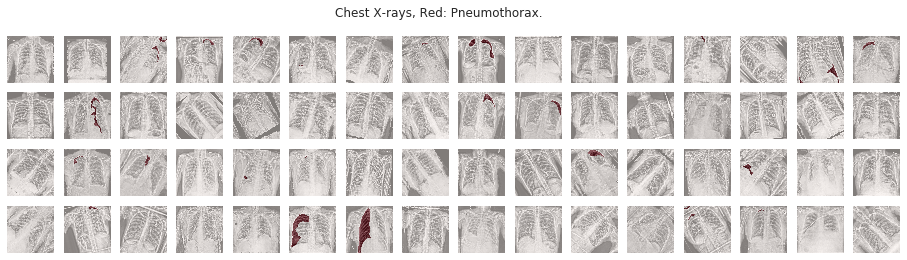

In [14]:
a = DataGenerator(batch_size=64,shuffle=False,augmentations=train_augment)
images,masks = a.__getitem__(0)
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))

for i,(im, mask) in enumerate(zip(images,masks)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im.squeeze(), cmap="bone")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Reds")    
    ax.axis('off')
plt.suptitle("Chest X-rays, Red: Pneumothorax.")

In [15]:
import segmentation_models as sm

Segmentation Models: using `keras` framework.


In [16]:
model = sm.Unet('resnet34', input_shape=(img_size,img_size,3), encoder_weights='imagenet',decoder_block_type='transpose')

AttributeError: ignored

In [0]:
class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')


In [0]:
class SnapshotCallbackBuilder:
    """Callback builder for snapshot ensemble training of a model.
    From the paper "Snapshot Ensembles: Train 1, Get M For Free" (
    https://openreview.net/pdf?id=BJYwwY9ll)
    Creates a list of callbacks, which are provided when training a model
    so as to save the model weights at certain epochs, and then sharply
    increase the learning rate.
    """

    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        """
        Initialize a snapshot callback builder.
        # Arguments:
            nb_epochs: total number of epochs that the model will be trained for.
            nb_snapshots: number of times the weights of the model will be saved.
            init_lr: initial learning rate
        """
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
            callbacks.ModelCheckpoint("./keras.model",monitor='val_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)



In [0]:
def get_iou_vector(A,B):
    batch_size = A.shape[0]
    metric = 0.0
    for i in range(batch_size):
        t,p = A[i],B[i]
        #print(t.dtype)
        p = tf.dtypes.cast(p, tf.float32)
        intersection = np.sum(t * p)
        true = np.sum(t)
        pred = np.sum(p)
        
        if(true == 0):
            metric += (pred == 0)
            
        union = true + pred - intersection
        iou = intersection / union
        iou = np.floor(max(0,(iou - 0.45) * 20)) / 10
        metric += iou
    return metric / batch_size
def iou_metric(label,pred):
    return tf.py_function(get_iou_vector,[label,pred > 0.5],tf.float64)

In [0]:
def dice_coeff(y_true,y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.cast(K.greater(K.flatten(y_pred),0.5),'float32')
    intersection = K.sum(y_true_f * y_pred_f)
    dice_coeff = (intersection * 2) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return dice_coeff
def dice_loss(y_true,y_pred):   
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice_coeff = (intersection * 2 + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1 - dice_coeff
def bce_dice_loss(y_true,y_pred):
    return binary_crossentropy(y_true,y_pred) + dice_loss(y_true,y_pred)
def bce_logdice_loss(y_true,y_pred):
    return binary_crossentropy(y_true,y_pred) - K.log(1. - dice_loss(y_true,y_pred))

In [0]:
#model.compile(loss = sm.losses.bce_jaccard_loss,optimizer = SGD(learning_rate = 0.0001, momentum=0.0, nesterov=False),metrics = [sm.metrics.iou_score])
model.compile(loss=bce_dice_loss, optimizer='adam', metrics=[iou_metric])

In [0]:
train_filepath = train_df['file_names'].tolist()
val_filepath = val_df['file_names'].tolist()
train_im_path = 'train'
train_mask_path = 'masks'
epochs = 50
snapshot = SnapshotCallbackBuilder(nb_epochs = epochs,nb_snapshots = 1, init_lr = 1e-3)
swa = SWA('./keras_swa.model',47)
batch_size = 4
train_generator = DataGenerator(filepath = train_filepath, augmentations=train_augment, batch_size = batch_size)
val_generator = DataGenerator(filepath = val_filepath, augmentations=train_augment, batch_size = batch_size)
history = model.fit_generator(train_generator,validation_data = val_generator,epochs = epochs,callbacks = snapshot.get_callbacks())